# ENCI 610.4: CT-GTFS Integration with Transit Route Analysis and Clustering

## Manual Comparison

### Mock script for general understanding

After this i utilized excel for some more data understanding and preprocessing:
- Used Excel filters to select a specific route and stop
- Sorted by arrival_time to see the sequence of buses
- Double-checked the route-specific and stop-specific CSV files with pre-calculated headways

## Creating New Database of CT_GTFS Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]


c:\Users\bilal\anaconda3\envs\endg511\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the relevant CT_GTFS files
trips_df = pd.read_csv('CT_GTFS/trips.txt')
calendar_df = pd.read_csv('CT_GTFS/calendar.txt')

# Count trips per route on weekdays
# Join trips with calendar to filter for weekday service
trips_with_service = pd.merge(trips_df, calendar_df, on='service_id')

# Filter for weekday service (Monday)
weekday_trips = trips_with_service[trips_with_service['monday'] == 1]

# Get weekday service_ids (Monday)
# weekday_service_ids = calendar_df[calendar_df['monday'] == 1]['service_id'].unique()
# print(weekday_service_ids)

# # Filter trips for weekday service
# weekday_trips = trips_df[trips_df['service_id'].isin(weekday_service_ids)]

# # Count trips per route for weekdays
# daily_trips = weekday_trips.groupby('route_id').size().reset_index(name='daily_trips')

# # Count trips per route
trips_per_route = weekday_trips.groupby('route_id').size().reset_index(name='daily_trips') # may need to divide by 2

# Map route_ids to your route numbers
routes_df = pd.read_csv('CT_GTFS/routes.txt')
trips_per_route = pd.merge(trips_per_route, routes_df[['route_id', 'route_short_name']], on='route_id')


# routes_df = pd.read_csv('CT_GTFS/routes.txt')
# trips_per_route = pd.merge(daily_trips, routes_df[['route_id', 'route_short_name']], on='route_id')


# Show results
print(f"Total routes with weekday service: {len(trips_per_route)}")
trips_per_route.head(10)

Total routes with weekday service: 267


,route_id,daily_trips,route_short_name
0,1-20760,304,1
1,10-20760,136,10
2,100-20760,166,100
3,101-20760,78,101
4,102-20760,194,102
5,104-20760,146,104
6,105-20760,142,105
7,106-20760,40,106
8,108-20760,148,108
9,109-20760,10,109


In [3]:
weekday_trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
13477,93-20760,2025MA-1BUSWK-Weekday-03,69506889,WESTBROOK STATION,0,6842687,930102,1,1,1,1,1,0,0,20250402,20250620
13478,93-20760,2025MA-1BUSWK-Weekday-03,69506890,COACH HILL,1,6842687,930141,1,1,1,1,1,0,0,20250402,20250620
13479,93-20760,2025MA-1BUSWK-Weekday-03,69506891,WESTBROOK STATION,0,6842687,930102,1,1,1,1,1,0,0,20250402,20250620
13480,93-20760,2025MA-1BUSWK-Weekday-03,69506892,COACH HILL,1,6842323,930141,1,1,1,1,1,0,0,20250402,20250620
13481,93-20760,2025MA-1BUSWK-Weekday-03,69506893,COACH HILL,1,6842584,930141,1,1,1,1,1,0,0,20250402,20250620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36378,201-20758,2025MA-1LRTWK-Weekday-00,69308387,SOMERSET-BRIDLEWOOD,1,6828055,2010503,1,1,1,1,1,0,0,20250402,20250620
36379,201-20758,2025MA-1LRTWK-Weekday-00,69308391,SOMERSET-BRIDLEWOOD,1,6828057,2010503,1,1,1,1,1,0,0,20250402,20250620
36380,201-20758,2025MA-1LRTWK-Weekday-00,69308395,SOMERSET-BRIDLEWOOD,1,6828061,2010546,1,1,1,1,1,0,0,20250402,20250620
36381,201-20758,2025MA-1LRTWK-Weekday-00,69308398,SOMERSET-BRIDLEWOOD,1,6828060,2010546,1,1,1,1,1,0,0,20250402,20250620


## Proxy Ridership Estimation - based on peak and off-peak ridership

In [ ]:
import pandas as pd
import numpy as np


# Step 1: Load the necessary GTFS data
def load_gtfs_data():
    # Load the required GTFS files
    stop_times_df = pd.read_csv('CT_GTFS/stop_times.txt')
    trips_df = pd.read_csv('CT_GTFS/trips.txt')
    routes_df = pd.read_csv('CT_GTFS/routes.txt')

    return stop_times_df, trips_df, routes_df

# Step 2: Process time format correctly
def process_time_format(stop_times_df):
    # Convert GTFS time format (HH:MM:SS) to minutes since midnight
    def time_to_minutes(time_str):
        try:
            h, m, s = map(int, time_str.split(':'))
            return h * 60 + m
        except:
            return np.nan
    
    # Apply the conversion
    stop_times_df['arrival_minutes'] = stop_times_df['arrival_time'].apply(time_to_minutes)
    
    # Display sample after time conversion
    print("\nSample after time conversion:")
    print(stop_times_df[['trip_id', 'arrival_time', 'arrival_minutes']].head(5))
    
    return stop_times_df

# Step 3: Calculate headways following your Excel approach
def calculate_headways(stop_times_df, trips_df, routes_df):
    # Join stop_times with trips to get route information
    
    # trips_with_service = pd.merge(trips_df, calendar_df, on='service_id')
    # weekday_trips = trips_with_service[trips_with_service['monday'] == 1]
    
    stop_times_with_routes = pd.merge(
        stop_times_df,
        trips_df[['trip_id', 'route_id', 'direction_id']],
        on='trip_id',
        how='left'
    )
    
    # Display sample after joining with trips
    print("\nSample after joining with trips:")
    print(stop_times_with_routes[['trip_id', 'route_id', 'direction_id', 'arrival_minutes']].head(5))
    
    # Join with routes to get route short names
    stop_times_with_routes = pd.merge(
        stop_times_with_routes,
        routes_df[['route_id', 'route_short_name']],
        on='route_id',
        how='left'
    )
    
    # Display sample after joining with routes
    print("\nSample after joining with routes:")
    print(stop_times_with_routes[['trip_id', 'route_id', 'route_short_name', 'direction_id', 'arrival_minutes']].head(5))
    
    # Filter for first stop in each trip's sequence (stop_sequence == 1)
    first_stops = stop_times_with_routes[stop_times_with_routes['stop_sequence'] == 1].copy()
    
    # Display first stops sample
    print("\nSample of first stops (stop_sequence == 1):")
    print(first_stops[['trip_id', 'route_id', 'route_short_name', 'direction_id', 'arrival_minutes']].head(5))
    print(f"\nNumber of first stops: {len(first_stops)}")
    
    # Define peak periods: Morning peak (7-9 AM) = 420-540 minutes
    morning_peak_start, morning_peak_end, afternoon_peak_start, afternoon_peak_end = 7*60, 9*60, 16*60, 18*60
    
    # Create peak/off-peak indicators
    first_stops['is_peak'] = (
        (first_stops['arrival_minutes'] >= morning_peak_start) & 
        (first_stops['arrival_minutes'] < morning_peak_end) |
        (first_stops['arrival_minutes'] >= afternoon_peak_start) &
        (first_stops['arrival_minutes'] < afternoon_peak_end) 
    )
    
    # Display sample with peak indicators
    print("\nSample with peak indicators:")
    print(first_stops[['trip_id', 'route_short_name', 'direction_id', 'arrival_minutes', 'is_peak']].head(10))
    
    # Show count of peak vs non-peak trips
    peak_count = first_stops['is_peak'].sum()
    print(f"\nTotal trips: {len(first_stops)}")
    print(f"Peak trips (7-9 AM): {peak_count}")
    print(f"Non-peak trips: {len(first_stops) - peak_count}")
    
    # Process each route and direction
    results = []
    
    # Get unique route_id, direction_id combinations
    route_directions = first_stops[['route_id', 'route_short_name', 'direction_id']].drop_duplicates()
    print(f"\nUnique route-direction combinations: {len(route_directions)}")
    
    # Process a sample route to demonstrate the headway calculation
    sample_route = route_directions.iloc[0]
    sample_route_id = sample_route['route_id']
    sample_route_name = sample_route['route_short_name']
    sample_direction = sample_route['direction_id']
    
    print(f"\nDemonstrating headway calculation for Route {sample_route_name}, Direction {sample_direction}:")
    
    # Filter for this route and direction
    sample_route_data = first_stops[
        (first_stops['route_id'] == sample_route_id) & 
        (first_stops['direction_id'] == sample_direction)
    ].sort_values('arrival_minutes')
    
    print("\nSample route data (sorted by arrival_minutes):")
    print(sample_route_data.head(10))
    
    # Calculate headways for sample route
    sample_route_data['next_arrival'] = sample_route_data['arrival_minutes'].shift(-1)
    sample_route_data['headway'] = sample_route_data['next_arrival'] - sample_route_data['arrival_minutes']
    
    print("\nSample route data with headway calculations:")
    print(sample_route_data[['trip_id', 'arrival_minutes', 'next_arrival', 'headway', 'is_peak']].head(10))
    
    # Calculate peak and non-peak headways for sample route
    peak_sample = sample_route_data[sample_route_data['is_peak']]
    non_peak_sample = sample_route_data[~sample_route_data['is_peak']]
    
    valid_peak_headways = peak_sample['headway'].dropna()
    valid_peak_headways = valid_peak_headways[(valid_peak_headways > 0) & (valid_peak_headways < 120)]
    
    valid_non_peak_headways = non_peak_sample['headway'].dropna()
    valid_non_peak_headways = valid_non_peak_headways[(valid_non_peak_headways > 0) & (valid_non_peak_headways < 120)]
    
    print(f"\nPeak trips for sample route: {len(peak_sample)}")
    print(f"Valid peak headway measurements: {len(valid_peak_headways)}")
    if len(valid_peak_headways) > 0:
        print(f"Average peak headway: {valid_peak_headways.mean():.2f} minutes")
    
    print(f"\nNon-peak trips for sample route: {len(non_peak_sample)}")
    print(f"Valid non-peak headway measurements: {len(valid_non_peak_headways)}")
    if len(valid_non_peak_headways) > 0:
        print(f"Average non-peak headway: {valid_non_peak_headways.mean():.2f} minutes")
    
    # Now process all routes and directions
    for _, row in route_directions.iterrows():
        route_id = row['route_id']
        route_short_name = row['route_short_name']
        direction_id = row['direction_id']
        
        # Filter for this route and direction
        route_data = first_stops[
            (first_stops['route_id'] == route_id) & 
            (first_stops['direction_id'] == direction_id)
        ].sort_values('arrival_minutes')
        
        # Count peak trips
        peak_trips = route_data[route_data['is_peak']].shape[0]
        
        # Calculate peak headways (if there are enough trips)
        peak_data = route_data[route_data['is_peak']].copy()
        
        if len(peak_data) > 1:
            # Calculate headways using the next arrival approach
            peak_data['next_arrival'] = peak_data['arrival_minutes'].shift(-1)
            peak_data['headway'] = peak_data['next_arrival'] - peak_data['arrival_minutes']
            
            # Filter out missing values and unreasonable headways
            valid_peak_headways = peak_data['headway'].dropna()
            valid_peak_headways = valid_peak_headways[(valid_peak_headways > 0) & (valid_peak_headways < 120)]
            
            if len(valid_peak_headways) > 0:
                avg_peak_headway = valid_peak_headways.mean()
            else:
                # Fallback to the original formula if we can't calculate direct headways
                avg_peak_headway = 120 / peak_trips if peak_trips > 0 else np.nan
        else:
            # Fallback to the original formula if we can't calculate direct headways
            avg_peak_headway = 120 / peak_trips if peak_trips > 0 else np.nan
        
        # Calculate non-peak headways
        non_peak_data = route_data[~route_data['is_peak']].copy()
        
        if len(non_peak_data) > 1:
            # Calculate headways using the next arrival approach
            non_peak_data['next_arrival'] = non_peak_data['arrival_minutes'].shift(-1)
            non_peak_data['headway'] = non_peak_data['next_arrival'] - non_peak_data['arrival_minutes']
            
            # Filter out missing values and unreasonable headways
            valid_non_peak_headways = non_peak_data['headway'].dropna()
            valid_non_peak_headways = valid_non_peak_headways[(valid_non_peak_headways > 0) & (valid_non_peak_headways < 120)]
            
            if len(valid_non_peak_headways) > 0:
                avg_non_peak_headway = valid_non_peak_headways.mean()
            else:
                avg_non_peak_headway = np.nan
        else:
            avg_non_peak_headway = np.nan
        
        # Store results
        results.append({
            'route_id': route_id,
            'route_short_name': route_short_name,
            'direction_id': direction_id,
            'peak_trips': peak_trips,
            'peak_headway_minutes': avg_peak_headway,
            'non_peak_headway_minutes': avg_non_peak_headway
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Display sample of detailed results
    print("\nSample of detailed results (by route and direction):")
    print(results_df.head(10))
    
    # Calculate statistics on the detailed results
    print("\nStatistics for peak_headway_minutes:")
    print(results_df['peak_headway_minutes'].describe())
    
    # For backward compatibility, create a version with just route_id and required columns
    peak_trips_per_route = results_df.groupby('route_id').agg({
        'peak_trips': 'sum',  # Sum trips across both directions
        'peak_headway_minutes': 'mean'  # Average headways across both directions
    }).reset_index()
    
    # Display the backward-compatible format
    print("\nSample of backward-compatible format:")
    print(peak_trips_per_route.head(10))
    
    return results_df, peak_trips_per_route



# Load data
stop_times_df, trips_df, routes_df = load_gtfs_data()

# Process time format
stop_times_df = process_time_format(stop_times_df)

# Calculate headways
detailed_results, peak_trips_per_route = calculate_headways(stop_times_df, trips_df, routes_df)

print("\nFINAL OUTPUTS:")
print("\nDetailed results by route and direction:")
print(detailed_results.head())

print("\nPeak trips per route (compatible format for your existing code):")
print(peak_trips_per_route.head())


Sample after time conversion:
    trip_id arrival_time  arrival_minutes
0  69492190     11:52:00              712
1  69492190     11:53:00              713
2  69492190     11:53:00              713
3  69492190     11:59:00              719
4  69492190     12:00:00              720

Sample after joining with trips:
    trip_id  route_id  direction_id  arrival_minutes
0  69492190  36-20760             0              712
1  69492190  36-20760             0              713
2  69492190  36-20760             0              713
3  69492190  36-20760             0              719
4  69492190  36-20760             0              720

Sample after joining with routes:
    trip_id  route_id  route_short_name  direction_id  arrival_minutes
0  69492190  36-20760                36             0              712
1  69492190  36-20760                36             0              713
2  69492190  36-20760                36             0              713
3  69492190  36-20760                36       

In [5]:
peak_trips_per_route

,route_id,peak_trips,peak_headway_minutes
0,1-20760,94,10.072619
1,10-20760,50,19.300000
2,100-20760,64,16.050000
3,101-20760,30,25.500000
4,102-20760,78,11.232026
...,...,...,...
263,95-20760,16,32.000000
264,96-20760,56,16.189103
265,97-20760,56,16.083333
266,98-20760,59,11.078947


In [6]:
detailed_results

,route_id,route_short_name,direction_id,peak_trips,peak_headway_minutes,non_peak_headway_minutes
0,36-20760,36,0,28,16.083333,19.725000
1,41-20760,41,0,22,16.500000,16.379310
2,28-20760,28,0,32,14.285714,16.039216
3,83-20760,83,0,31,14.428571,14.769231
4,40-20760,40,0,26,16.454545,20.812500
...,...,...,...,...,...,...
477,873-20760,873,1,0,NaN,NaN
478,201-20758,201,0,277,1.983051,2.580569
479,201-20758,201,1,281,2.833333,2.939726
480,202-20758,202,1,205,2.500000,3.477663


In [7]:
# Make sure we have arrival_minutes
if 'arrival_minutes' not in stop_times_df.columns:
    stop_times_df['arrival_minutes'] = stop_times_df['arrival_time'].apply(time_to_minutes)


# For each route, find the first and last stop time
first_last_times = stop_times_df.join(
    trips_df.set_index('trip_id'), on='trip_id'
).groupby('route_id').agg(
    first_service_min=('arrival_minutes', 'min'),
    last_service_min=('arrival_minutes', 'max')
)

# # Calculate service hours
# first_last_times['service_hours'] = (
#     first_last_times['last_service'] - first_last_times['first_service']
# ).dt.total_seconds() / 3600

# Calculate service hours
first_last_times['service_hours'] = (
    first_last_times['last_service_min'] - first_last_times['first_service_min']
) / 60

first_last_times

,first_service_min,last_service_min,service_hours
route_id,,,
1-20760,271,1546,21.250000
10-20760,340,1467,18.783333
100-20760,301,1574,21.216667
101-20760,350,1308,15.966667
102-20760,282,1491,20.150000
...,...,...,...
95-20760,302,1130,13.800000
96-20760,314,1467,19.216667
97-20760,312,1446,18.900000


In [ ]:
# Create a ridership proxy based on:
# 1. Trip frequency (more trips = more riders)
# 2. Service hours (longer service = more diverse ridership)
# 3. Number of stops served (more stops = more access points)

daily_trips = trips_df.groupby('route_id').size().reset_index(name='daily_trips')

# Merge with peak trips information from detailed_results
# We'll sum peak_trips across directions for each route
peak_trips_summary = detailed_results.groupby('route_id')['peak_trips'].sum().reset_index()

# Calculate non-peak trips as daily_trips - peak_trips
trips_summary = pd.merge(daily_trips, peak_trips_summary, on='route_id', how='left')
trips_summary['non_peak_trips'] = trips_summary['daily_trips'] - trips_summary['peak_trips']

# Count stops per route
stop_times_with_routes = pd.merge(
    stop_times_df, 
    trips_df[['trip_id', 'route_id']], 
    on='trip_id'
)
stops_per_route = stop_times_with_routes.groupby('route_id')['stop_id'].nunique().reset_index(name='stop_count')

ridership_proxy = pd.merge(trips_summary, stops_per_route, on='route_id', how='left')
ridership_proxy = pd.merge(ridership_proxy, first_last_times[['service_hours']], on='route_id', how='left')

# Add route information for easier joining later
routes_df = pd.read_csv('CT_GTFS/routes.txt')
ridership_proxy = pd.merge(
    ridership_proxy,
    routes_df[['route_id', 'route_short_name', 'route_long_name']],
    on='route_id',
    how='left'
)

# 4. Calculate  ridership proxy with separate weights for peak and non-peak trips
# This gives more weight to peak trips since they often represent higher ridership
ridership_proxy['estimated_riders'] = (
    ridership_proxy['peak_trips'] * 0.5 +           # Higher weight for peak trips
    ridership_proxy['non_peak_trips'] * 0.2 +       # Lower weight for non-peak trips
    ridership_proxy['stop_count'] * 0.2 +           # Same weight for stop coverage
    ridership_proxy['service_hours'] * 0.1          # Same weight for service span
) * 100  # Scale factor

In [9]:
ridership_proxy #i just realized my peak hours keep the weekend timing

,route_id,daily_trips,peak_trips,non_peak_trips,stop_count,service_hours,route_short_name,route_long_name,estimated_riders
0,1-20760,482,94,388,137,21.250000,1,Bowness/Forest Lawn,15412.500000
1,10-20760,252,50,202,90,18.783333,10,City Hall/Southcentre,8527.833333
2,100-20760,324,64,260,41,21.216667,100,Airport,9432.166667
3,101-20760,128,30,98,35,15.966667,101,Inglewood,4319.666667
4,102-20760,338,78,260,42,20.150000,102,Millrise/Silverado,10141.500000
...,...,...,...,...,...,...,...,...,...
263,95-20760,30,16,14,34,13.800000,95,Palliser,1898.000000
264,96-20760,229,56,173,84,19.216667,96,McKenzie,8132.166667
265,97-20760,258,56,202,48,18.900000,97,South Ranchlands/Scenic Acres,7989.000000
266,98-20760,266,59,207,37,18.966667,98,Cougar Ridge,8019.666667


## Integrating with Existing Dataset

In [10]:
import pandas as pd
import numpy as np

def calculate_improved_ridership_proxy(stop_times_df, trips_df, detailed_results):
    """
    Calculate an improved ridership proxy using separate peak and non-peak trips
    """
    # 1. Calculate non-peak trips for each route
    # First, get the total daily trips for each route
    daily_trips = trips_df.groupby('route_id').size().reset_index(name='daily_trips')
    
    # Merge with peak trips information from detailed_results
    # We'll sum peak_trips across directions for each route
    peak_trips_summary = detailed_results.groupby('route_id')['peak_trips'].sum().reset_index()
    
    # Calculate non-peak trips as daily_trips - peak_trips
    trips_summary = pd.merge(daily_trips, peak_trips_summary, on='route_id', how='left')
    trips_summary['non_peak_trips'] = trips_summary['daily_trips'] - trips_summary['peak_trips']
    
    # 2. Join with service hours and stop count (assuming these are already calculated)
    # Join stop_times with trips to get route_id
    stop_times_with_routes = pd.merge(
        stop_times_df, 
        trips_df[['trip_id', 'route_id']], 
        on='trip_id'
    )
    
    # Convert arrival_time to minutes if not already done
    if 'arrival_minutes' not in stop_times_df.columns:
        def time_to_minutes(time_str):
            try:
                h, m, s = map(int, time_str.split(':'))
                return h * 60 + m
            except:
                return np.nan
        
        stop_times_with_routes['arrival_minutes'] = stop_times_with_routes['arrival_time'].apply(time_to_minutes)
    
    # Calculate service hours
    first_last_times = stop_times_with_routes.groupby('route_id').agg(
        first_service_min=('arrival_minutes', 'min'),
        last_service_min=('arrival_minutes', 'max')
    )
    first_last_times['service_hours'] = (first_last_times['last_service_min'] - first_last_times['first_service_min']) / 60
    
    # Count stops per route
    stops_per_route = stop_times_with_routes.groupby('route_id')['stop_id'].nunique().reset_index(name='stop_count')
    
    # 3. Merge everything together for the ridership proxy calculation
    ridership_proxy = pd.merge(trips_summary, stops_per_route, on='route_id', how='left')
    ridership_proxy = pd.merge(ridership_proxy, first_last_times[['service_hours']], on='route_id', how='left')
    
    # Add route information for easier joining later
    routes_df = pd.read_csv('CT_GTFS/routes.txt')
    ridership_proxy = pd.merge(
        ridership_proxy,
        routes_df[['route_id', 'route_short_name', 'route_long_name']],
        on='route_id',
        how='left'
    )
    
    # 4. Calculate improved ridership proxy with separate weights for peak and non-peak trips
    # This gives more weight to peak trips since they often represent higher ridership
    ridership_proxy['estimated_riders'] = (
        ridership_proxy['peak_trips'] * 0.4 +           # Higher weight for peak trips
        ridership_proxy['non_peak_trips'] * 0.2 +       # Lower weight for non-peak trips
        ridership_proxy['stop_count'] * 0.3 +           # Same weight for stop coverage
        ridership_proxy['service_hours'] * 0.1          # Same weight for service span
    ) * 100  # Scale factor
    
    return ridership_proxy

def clean_enhanced_df(enhanced_df):
    """
    Clean up and organize the enhanced DataFrame for better readability and analysis
    """
    # 1. Remove duplicate columns (route_short_name is duplicated with Route_Short_Name)
    if 'route_short_name' in enhanced_df.columns:
        enhanced_df = enhanced_df.drop(columns=['route_short_name'])
    
    # 2. Rename columns for consistency
    column_renames = {
        'Route_Short_Name': 'route_number',           # More descriptive
        'Route_Long_Name': 'route_name',              # More descriptive
        'Traffic_Volume': 'traffic_volume',           # Consistent lowercase with underscores
        'Incidents': 'incidents',                     # Consistent lowercase
        'Number_of_Bus-Only-Lanes': 'bus_only_lanes'  # Easier to work with (no hyphens)
    }
    
    enhanced_df = enhanced_df.rename(columns=column_renames)
    
    # 3. Organize columns into logical groups
    # Route identifiers
    id_cols = ['route_id', 'route_number', 'route_name']
    
    # Service metrics
    service_cols = ['daily_trips', 'peak_trips', 'non_peak_trips', 'service_hours']
    
    # Headway metrics
    headway_cols = ['peak_headway_minutes', 'non_peak_headway_minutes']
    
    # Traffic and incidents
    traffic_cols = ['traffic_volume', 'incidents', 'bus_only_lanes']
    
    # Derived metrics
    derived_cols = ['estimated_riders', 'stop_count']
    
    # Any other columns not in these groups
    other_cols = [col for col in enhanced_df.columns 
                 if col not in id_cols + service_cols + headway_cols + traffic_cols + derived_cols]
    
    # Reorder columns
    ordered_cols = id_cols + service_cols + headway_cols + traffic_cols + derived_cols + other_cols
    
    # Check that all columns exist before reordering
    existing_ordered_cols = [col for col in ordered_cols if col in enhanced_df.columns]
    enhanced_df = enhanced_df[existing_ordered_cols]
    
    # 4. Add derived metrics if they don't exist
    if 'trips_per_hour' not in enhanced_df.columns and 'service_hours' in enhanced_df.columns:
        enhanced_df['trips_per_hour'] = enhanced_df['daily_trips'] / enhanced_df['service_hours']
    
    if 'incidents_per_trip' not in enhanced_df.columns:
        enhanced_df['incidents_per_trip'] = enhanced_df['incidents'] / enhanced_df['daily_trips']
    
    return enhanced_df

# Example of how to use these functions with your existing code
def update_analysis_with_improved_metrics(stop_times_df, trips_df, detailed_results, existing_df):
    """
    Update the analysis with improved ridership proxy and enhanced DataFrame cleanup
    """
    # Calculate improved ridership proxy
    ridership_proxy = calculate_improved_ridership_proxy(stop_times_df, trips_df, detailed_results)
    
    # Prepare the GTFS metrics for joining
    CT_GTFS_metrics = ridership_proxy[[
        'route_id', 
        'route_short_name', 
        'daily_trips', 
        'peak_trips', 
        'non_peak_trips',
        'estimated_riders'
    ]]
    
    # Add headway information
    peak_headways = detailed_results.groupby('route_id')['peak_headway_minutes'].mean().reset_index()
    non_peak_headways = detailed_results.groupby('route_id')['non_peak_headway_minutes'].mean().reset_index()
    
    CT_GTFS_metrics = pd.merge(CT_GTFS_metrics, peak_headways, on='route_id', how='left')
    CT_GTFS_metrics = pd.merge(CT_GTFS_metrics, non_peak_headways, on='route_id', how='left')
    
    # Rename column to match existing_df
    CT_GTFS_metrics.rename(columns={'route_short_name': 'Route_Short_Name'}, inplace=True)
    
    # Merge with existing data
    enhanced_df = pd.merge(
        existing_df,
        CT_GTFS_metrics,
        on='Route_Short_Name',
        how='left'
    )
    
    # Clean and organize the enhanced DataFrame
    enhanced_df = clean_enhanced_df(enhanced_df)
    
    return enhanced_df, ridership_proxy

ridership_proxy

,route_id,daily_trips,peak_trips,non_peak_trips,stop_count,service_hours,route_short_name,route_long_name,estimated_riders
0,1-20760,482,94,388,137,21.250000,1,Bowness/Forest Lawn,15412.500000
1,10-20760,252,50,202,90,18.783333,10,City Hall/Southcentre,8527.833333
2,100-20760,324,64,260,41,21.216667,100,Airport,9432.166667
3,101-20760,128,30,98,35,15.966667,101,Inglewood,4319.666667
4,102-20760,338,78,260,42,20.150000,102,Millrise/Silverado,10141.500000
...,...,...,...,...,...,...,...,...,...
263,95-20760,30,16,14,34,13.800000,95,Palliser,1898.000000
264,96-20760,229,56,173,84,19.216667,96,McKenzie,8132.166667
265,97-20760,258,56,202,48,18.900000,97,South Ranchlands/Scenic Acres,7989.000000
266,98-20760,266,59,207,37,18.966667,98,Cougar Ridge,8019.666667


In [12]:
# Loading existing dataset from Analysis Phase 2
existing_df = pd.read_csv('./analysis-phase-2/zTransit_route_analysis.csv')

# Prepare the GTFS metrics for joining
CT_GTFS_metrics = ridership_proxy[['route_id','route_short_name', 'daily_trips', 'estimated_riders']]
CT_GTFS_metrics = pd.merge(CT_GTFS_metrics, peak_trips_per_route[['route_id', 'peak_headway_minutes']], on='route_id')
CT_GTFS_metrics.rename(columns={'route_short_name': 'Route_Short_Name'}, inplace=True)
# CT_GTFS_metrics
# Add non-peak headway information
CT_GTFS_metrics = pd.merge(
    CT_GTFS_metrics,
    detailed_results.groupby('route_id').agg({
        # 'route_short_name': 'first',
        'non_peak_headway_minutes': 'mean',
        'peak_trips': 'sum'
    }),
    on='route_id',
    how='left'
)


# Merge with your existing data
# Note: Ensure route identifiers match between datasets
enhanced_df = pd.merge(
    existing_df,
    CT_GTFS_metrics,
    on='Route_Short_Name',  # Adjust column name as needed
    how='left'
)
enhanced_df


,Route_Short_Name,Route_Long_Name,Traffic_Volume,Incidents,Number_of_Bus-Only-Lanes,route_id,daily_trips,estimated_riders,peak_headway_minutes,non_peak_headway_minutes,peak_trips
0,38,Brentwood Station/Temple,365330,1228,0,38-20760,561,17137.666667,8.017857,9.569117,122
1,68,68 St E,257550,1212,0,68-20760,218,7577.666667,15.965035,19.500000,58
2,150,114 Av SE,476980,1169,0,150-20760,126,4697.833333,19.600000,20.000000,40
3,555,Dashmesh Centre,58000,1119,1,555-20760,11,1764.666667,60.000000,60.000000,4
4,440,Chateau Estates/Franklin Station,116550,701,0,440-20760,46,2405.500000,56.500000,56.166667,18
...,...,...,...,...,...,...,...,...,...,...,...
146,201,Red Line,921140,2129,0,201-20758,2806,74068.833333,2.408192,2.760147,558
147,174,Tuscany,0,22,0,174-20760,60,2506.333333,29.666667,29.631579,16
148,169,Rocky Ridge,0,51,0,169-20760,130,4028.500000,15.636364,17.458333,26
149,108,Paskapoo Slopes,231000,364,0,108-20760,234,7751.333333,17.541667,18.956395,56


In [13]:
nan_rows = enhanced_df[enhanced_df.isnull().any(axis=1)]

# Printing rows with NaN values
nan_rows

# print("Unique route_id in CT_GTFS_metrics:", CT_GTFS_metrics['route_id'].unique())
# print("Unique route_id in peak_trips_per_route:", peak_trips_per_route['route_id'].unique())
# print("Unique route_short_name in existing_df:", existing_df['route_short_name'].unique())

enhanced_df = enhanced_df.dropna()
enhanced_df.head(10)


,Route_Short_Name,Route_Long_Name,Traffic_Volume,Incidents,Number_of_Bus-Only-Lanes,route_id,daily_trips,estimated_riders,peak_headway_minutes,non_peak_headway_minutes,peak_trips
0,38,Brentwood Station/Temple,365330,1228,0,38-20760,561,17137.666667,8.017857,9.569117,122
1,68,68 St E,257550,1212,0,68-20760,218,7577.666667,15.965035,19.500000,58
2,150,114 Av SE,476980,1169,0,150-20760,126,4697.833333,19.600000,20.000000,40
3,555,Dashmesh Centre,58000,1119,1,555-20760,11,1764.666667,60.000000,60.000000,4
4,440,Chateau Estates/Franklin Station,116550,701,0,440-20760,46,2405.500000,56.500000,56.166667,18
5,43,McKnight - Westwinds Station/Chinook Station,747780,2804,0,43-20760,560,18276.833333,7.335929,9.517337,128
6,101,Inglewood,430000,1001,2,101-20760,128,4319.666667,25.500000,28.280435,30
7,4,Huntington,500000,1776,0,4-20760,191,6753.833333,11.200000,12.132353,44
8,80,Homestead,47950,161,0,80-20760,30,1674.666667,30.000000,30.750000,16
9,75,Somerset - Mahogany,419420,795,0,75-20760,304,10241.833333,12.549020,15.421532,74


In [ ]:
# Assuming enhanced_df is already loaded as a DataFrame

# Remove 'route_id' column - make sure you dont run this twice
# enhanced_df = enhanced_df.drop(columns=['route_id'])

# Rearrange columns
# Define the new column order based on your requirements
new_column_order = [
    'Route_Short_Name', 
    'Route_Long_Name', 
    'Number_of_Bus-Only-Lanes', 
    'daily_trips', 
    'peak_trips',  # Move peak_trips next to daily_trips
    'peak_headway_minutes', 
    'non_peak_headway_minutes', 
    'Traffic_Volume',  # Move Traffic_Volume to the end
    'Incidents',       # Move Incidents to the end
    'estimated_riders' # Move estimated_riders to the end
]

# Apply the new column order
enhanced_df = enhanced_df[new_column_order]

# Step 3: Display the updated DataFrame columns to verify changes
print("Updated DataFrame columns:")
print(enhanced_df.columns.tolist())

# Display a sample of the updated DataFrame
print("\nSample of updated DataFrame:")
enhanced_df.head()

enhanced_df.to_excel('enhanced_data.xlsx', index=False)

Updated DataFrame columns:
['Route_Short_Name', 'Route_Long_Name', 'Number_of_Bus-Only-Lanes', 'daily_trips', 'peak_trips', 'peak_headway_minutes', 'non_peak_headway_minutes', 'Traffic_Volume', 'Incidents', 'estimated_riders']

Sample of updated DataFrame:


## Clustering Analysis using GTFS Data 

Prioirity Score

In [16]:
# Create a priority score that considers both traffic and transit factors
enhanced_df['Priority_Score'] = (
    # Traffic factors (50%)
    (enhanced_df['Traffic_Volume'] / enhanced_df['Traffic_Volume'].max() * 0.3) +
    (enhanced_df['Incidents'] / enhanced_df['Incidents'].max() * 0.2) +
    
    # Transit factors (50%)
    (enhanced_df['estimated_riders'] / enhanced_df['estimated_riders'].max() * 0.3) +
    (1 - enhanced_df['peak_headway_minutes'] / enhanced_df['peak_headway_minutes'].max()) * 0.2
)

# Adjust score for routes that already have bus lanes
enhanced_df['Priority_Score'] = enhanced_df['Priority_Score'] * (1 - 0.3 * enhanced_df['Number_of_Bus-Only-Lanes'])

# Find the top priority routes
top_priority = enhanced_df.sort_values('Priority_Score', ascending=False).head(10)

In [17]:
enhanced_df

,Route_Short_Name,Route_Long_Name,Number_of_Bus-Only-Lanes,daily_trips,peak_trips,peak_headway_minutes,non_peak_headway_minutes,Traffic_Volume,Incidents,estimated_riders,Cluster,Priority_Score
0,38,Brentwood Station/Temple,0,561,122,8.017857,9.569117,365330,1228,17137.666667,2,0.349634
1,68,68 St E,0,218,58,15.965035,19.500000,257550,1212,7577.666667,1,0.266697
2,150,114 Av SE,0,126,40,19.600000,20.000000,476980,1169,4697.833333,1,0.275986
3,555,Dashmesh Centre,1,11,4,60.000000,60.000000,58000,1119,1764.666667,0,0.042715
4,440,Chateau Estates/Franklin Station,0,46,18,56.500000,56.166667,116550,701,2405.500000,0,0.067876
...,...,...,...,...,...,...,...,...,...,...,...,...
146,201,Red Line,0,2806,558,2.408192,2.760147,921140,2129,74068.833333,3,0.723008
147,174,Tuscany,0,60,16,29.666667,29.631579,0,22,2506.333333,0,0.112141
148,169,Rocky Ridge,0,130,26,15.636364,17.458333,0,51,4028.500000,1,0.166232
149,108,Paskapoo Slopes,0,234,56,17.541667,18.956395,231000,364,7751.333333,1,0.224077


please work. im exhausted

Loaded dataset with 150 routes and 10 features

Missing values per column:
Route_Short_Name            0
Route_Long_Name             0
Number_of_Bus-Only-Lanes    0
daily_trips                 0
peak_trips                  0
peak_headway_minutes        0
non_peak_headway_minutes    0
Traffic_Volume              0
Incidents                   0
estimated_riders            0
dtype: int64

Checking for problematic values in the original dataset:

After cleaning, missing values per column:
Route_Short_Name            0
Route_Long_Name             0
Number_of_Bus-Only-Lanes    0
daily_trips                 0
peak_trips                  0
peak_headway_minutes        0
non_peak_headway_minutes    0
Traffic_Volume              0
Incidents                   0
estimated_riders            0
dtype: int64

Created new metrics:
- priority_metric: Need for bus lane implementation (0-100)
- flow_impedance: Traffic flow disruption (0-100)

Descriptive statistics for new metrics:
       priority_metric  

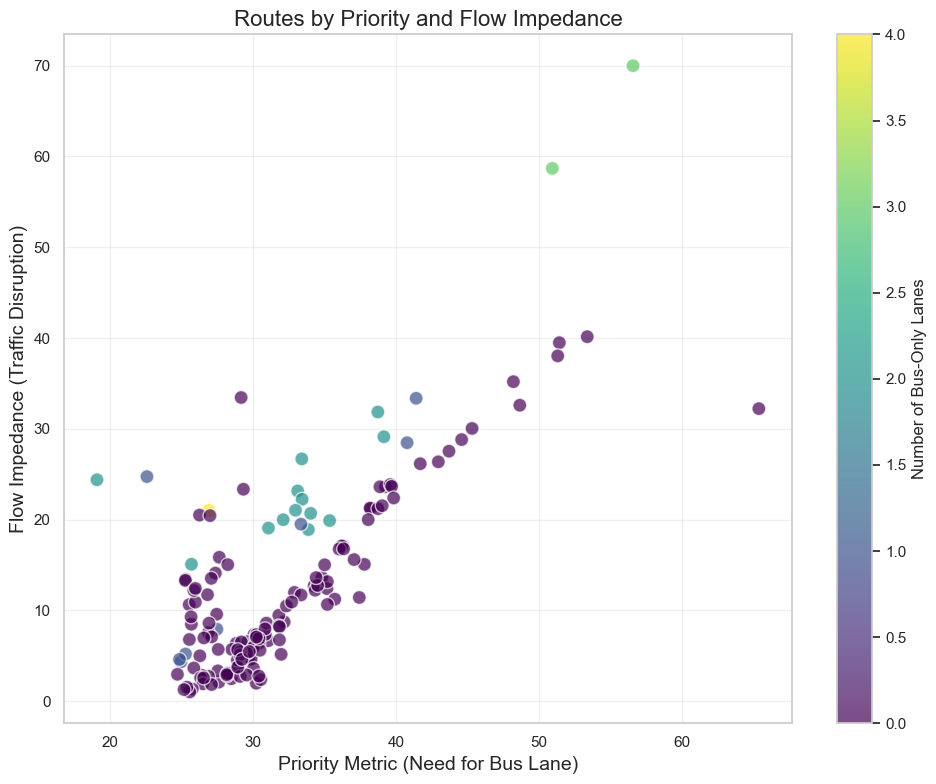

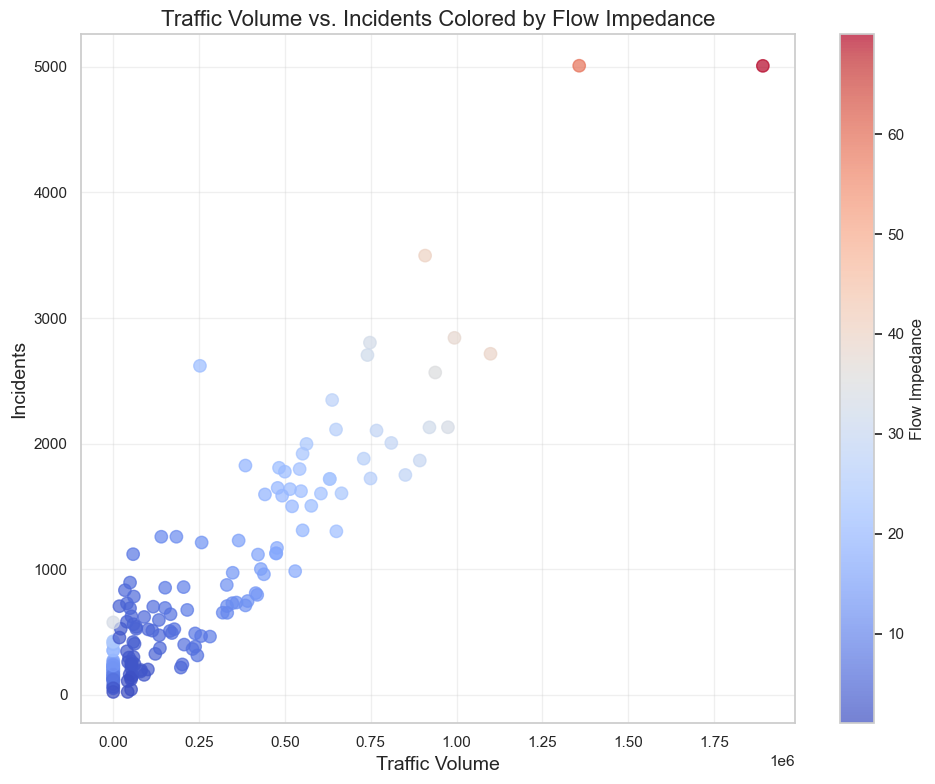


Preparing features for clustering...

Checking for problematic values in features before scaling:
Data is clean and ready for scaling.


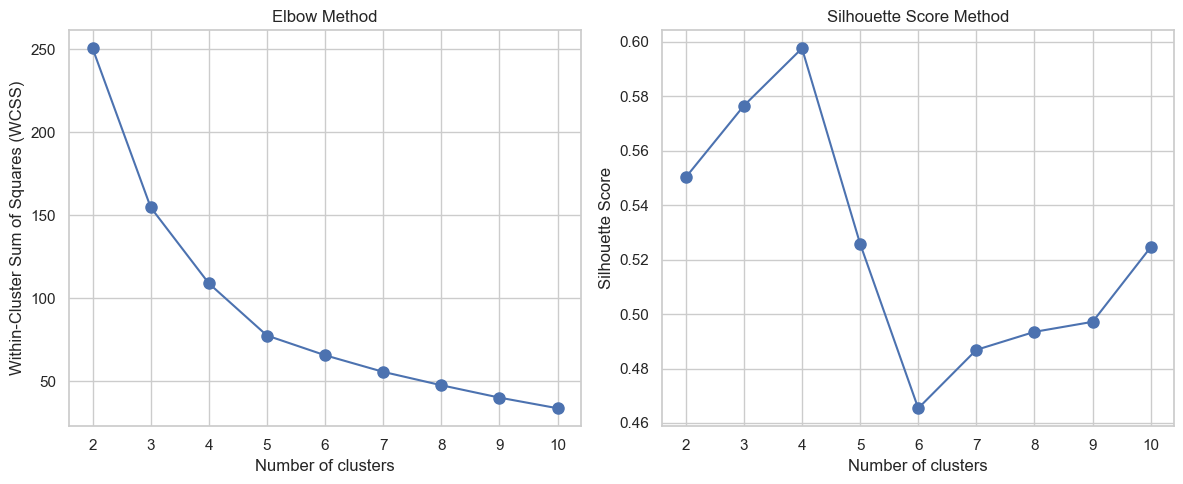


Optimal number of clusters based on silhouette score: 4


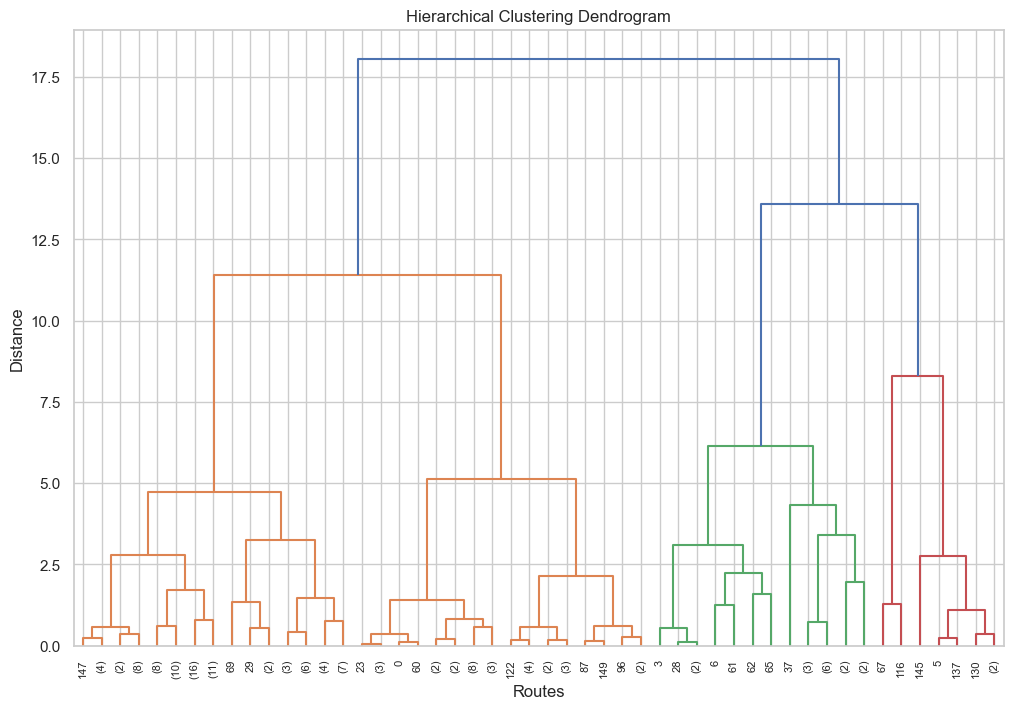


Cluster sizes:
Cluster 0: 30 routes
Cluster 1: 102 routes
Cluster 2: 16 routes
Cluster 3: 2 routes

Cluster statistics:
         Count  Number_of_Bus-Only-Lanes  daily_trips  peak_trips  \
Cluster                                                             
0           30                  0.066667   378.900000    87.20000   
1          102                  0.039216   206.029412    50.77451   
2           16                  2.000000   274.875000    66.00000   
3            2                  3.000000    10.000000     5.00000   

         peak_headway_minutes  Traffic_Volume    Incidents  estimated_riders  \
Cluster                                                                        
0                   13.590441    6.587743e+05  1808.266667      11963.761111   
1                   17.574151    1.113858e+05   440.411765       6783.759804   
2                   17.736913    4.628419e+05  1636.062500       8915.864583   
3                   45.000000    1.624880e+06  5008.500000      

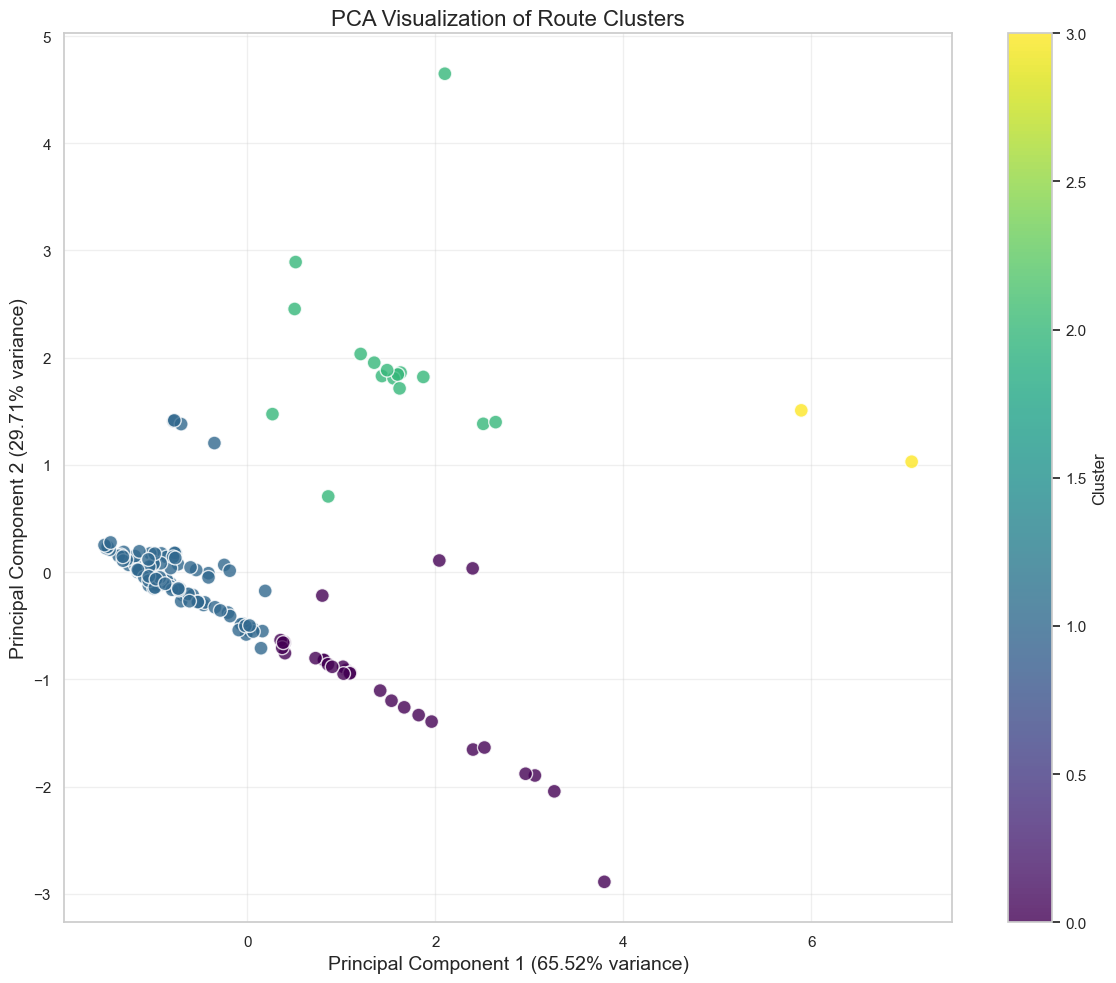

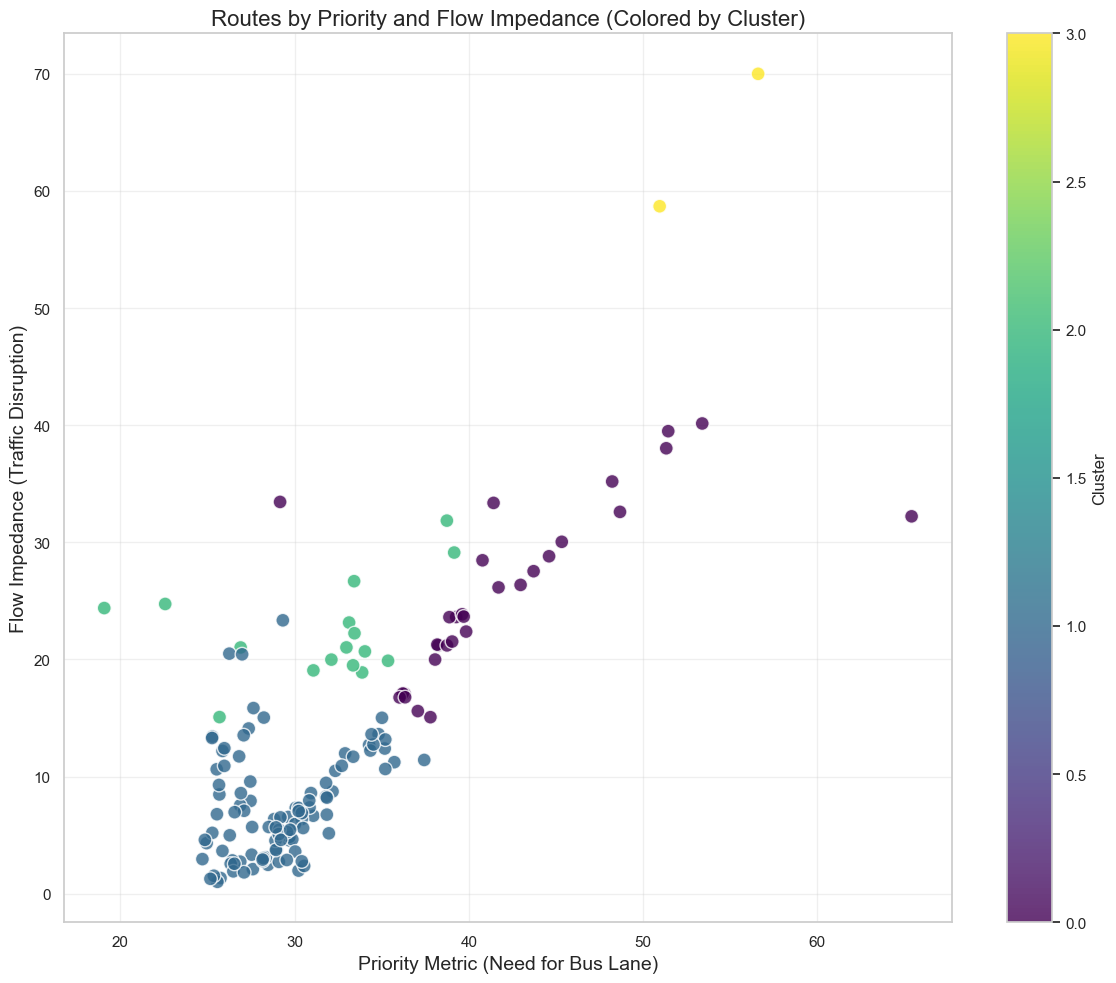

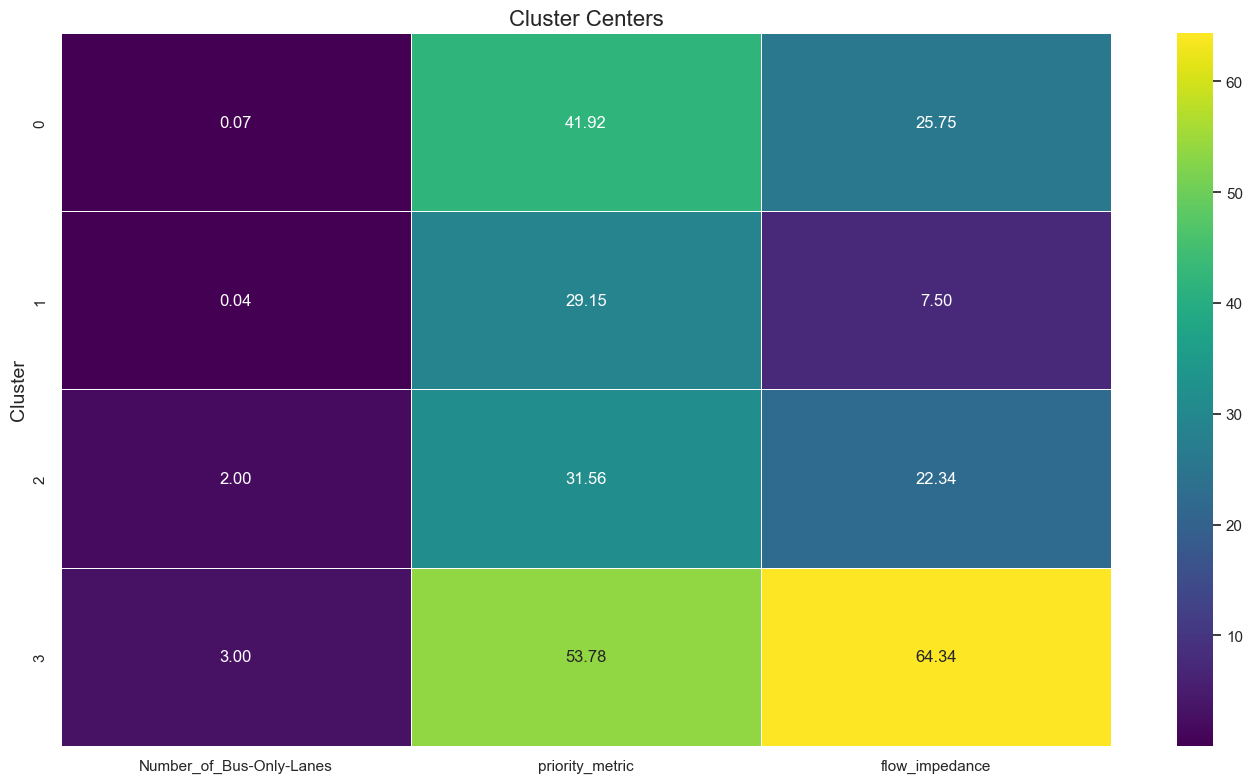


Comparison of routes with and without bus lanes:
                  With_Bus_Lanes  Without_Bus_Lanes
daily_trips           225.166667         249.174603
peak_trips             54.125000          60.015873
estimated_riders     7533.000000        8067.347884
Traffic_Volume     526551.250000      231290.317460
Incidents            1800.250000         731.412698
priority_metric        33.218417          32.109680
flow_impedance         23.747897          11.533827


<Figure size 1200x800 with 0 Axes>

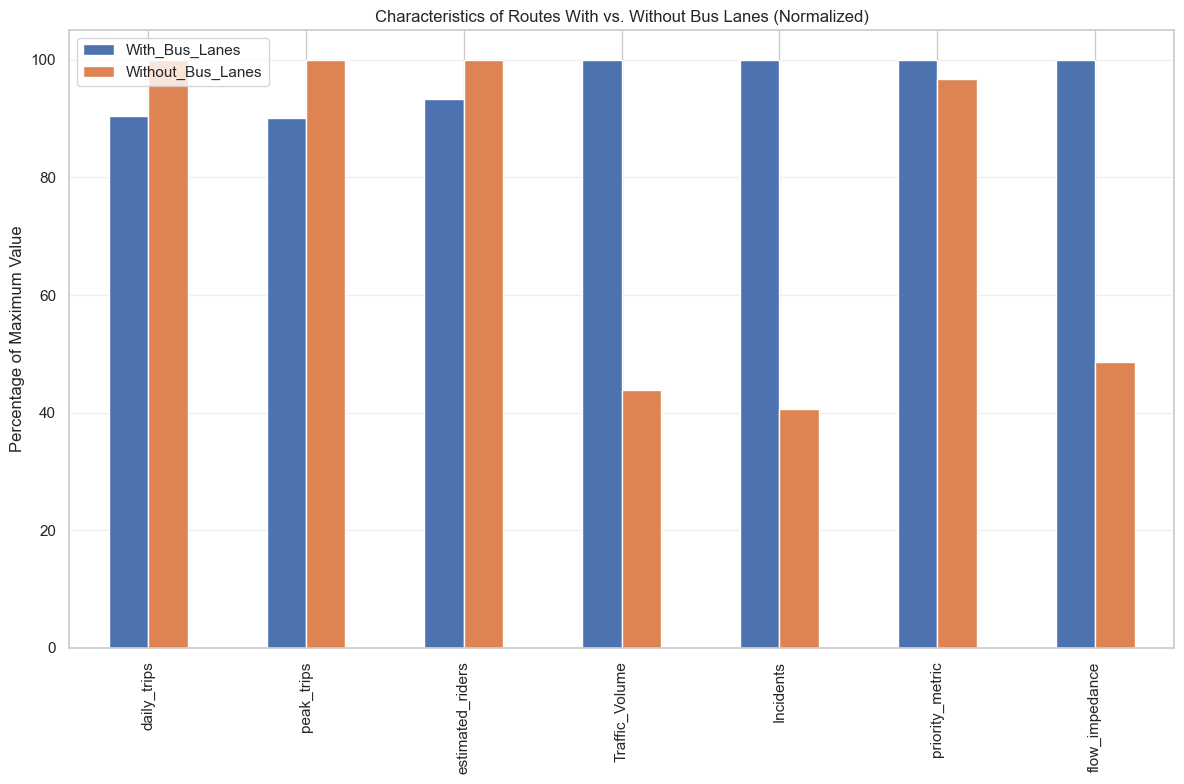


Enforcement and Implementation Recommendations by Cluster:

Cluster 0 (30 routes):
  Average Priority Metric: 41.92
  Average Flow Impedance: 25.75
  Bus Lane Coverage: 6.67%
  Average Ridership: 11963.76
  Example Routes: [38, 150, 43, 4, 20]
  Recommendations:
    - High priority for new bus lane implementation
    - Focus enforcement on reducing traffic disruptions
    - Implement targeted incident management strategies
    - Prioritize improvements to benefit high number of transit users

Cluster 1 (102 routes):
  Average Priority Metric: 29.15
  Average Flow Impedance: 7.50
  Bus Lane Coverage: 3.92%
  Average Ridership: 6783.76
  Example Routes: [68, 555, 440, 80, 75]
  Recommendations:

Cluster 2 (16 routes):
  Average Priority Metric: 31.56
  Average Flow Impedance: 22.34
  Bus Lane Coverage: 100.00%
  Average Ridership: 8915.86
  Example Routes: [101, 300, 302, 307, 3]
  Recommendations:
    - Extend existing bus lanes to cover more of these routes
    - Focus enforcement on 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
df = pd.read_csv('./analysis-phase-3/final_db_for_clustering_hopefully.csv')
print(f"Loaded dataset with {df.shape[0]} routes and {df.shape[1]} features")

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Identify columns with NaN values or infinite values
def print_problematic_rows(df):
    # Check for NaN values
    nan_rows = df.isna().any(axis=1)
    if nan_rows.any():
        print(f"\nFound {nan_rows.sum()} rows with NaN values:")
        print(df[nan_rows])
    
    # Check for infinite values
    inf_mask = df.replace([np.inf, -np.inf], np.nan).isna() & ~df.isna()
    inf_rows = inf_mask.any(axis=1)
    if inf_rows.any():
        print(f"\nFound {inf_rows.sum()} rows with infinite values:")
        print(df[inf_rows])

print("\nChecking for problematic values in the original dataset:")
print_problematic_rows(df)

# More thorough data cleaning
for col in df.columns:
    # Replace infinites with NaN first
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    
    # Count NaNs
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        print(f"Column {col} has {nan_count} NaN values. Filling with median.")
        # Fill NaN with median
        median_val = df[col].median()
        if pd.isna(median_val):  # If median itself is NaN (all values are NaN)
            print(f"  All values in {col} are NaN. Filling with 0.")
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(median_val)

# Double-check for any remaining missing values
print("\nAfter cleaning, missing values per column:")
print(df.isnull().sum())

# Create new metrics

# 1. Priority Metric - need for bus lane implementation
df['priority_metric'] = (
    # Transit demand component (40%)
    (0.4 * (
        (df['estimated_riders'] / df['estimated_riders'].max()) * 0.6 +
        (df['peak_trips'] / df['daily_trips']) * 0.4
    )) +
    
    # Traffic impedance component (40%)
    (0.4 * (
        (df['Traffic_Volume'] / df['Traffic_Volume'].max()) * 0.5 +
        (df['Incidents'] / df['Incidents'].max()) * 0.5
    )) +
    
    # Existing infrastructure penalty (20%)
    # Routes with more bus lanes get lower priority
    (0.2 * (1 - (df['Number_of_Bus-Only-Lanes'] / (df['Number_of_Bus-Only-Lanes'].max() + 1))))
) * 100

# Check for any NaN or infinite values in priority_metric
if df['priority_metric'].isna().any() or np.isinf(df['priority_metric']).any():
    print("\nDetected NaN or infinite values in priority_metric. Fixing...")
    df['priority_metric'] = df['priority_metric'].replace([np.inf, -np.inf], np.nan)
    df['priority_metric'] = df['priority_metric'].fillna(df['priority_metric'].median())

# 2. Flow Impedance Metric - traffic flow disruption
# Calculate incidents per traffic volume (higher ratio = worse flow)
# Avoid division by zero by adding a small constant
df['incident_to_volume_ratio'] = df['Incidents'] / (df['Traffic_Volume'] + 1e-10)

# Calculate volume per incident (higher ratio = better flow)
df['volume_to_incident_ratio'] = df['Traffic_Volume'] / (df['Incidents'] + 1)

# Normalize these ratios
max_inc_ratio = df['incident_to_volume_ratio'].max()
max_vol_ratio = df['volume_to_incident_ratio'].max()

df['normalized_incident_ratio'] = df['incident_to_volume_ratio'] / max_inc_ratio if max_inc_ratio > 0 else 0
df['normalized_volume_ratio'] = df['volume_to_incident_ratio'] / max_vol_ratio if max_vol_ratio > 0 else 0

# Flow impedance metric (higher = worse flow)
df['flow_impedance'] = (
    # Base component from traffic volume
    (df['Traffic_Volume'] / df['Traffic_Volume'].max()) * 0.4 +
    
    # Incident component
    (df['Incidents'] / df['Incidents'].max()) * 0.3 +
    
    # Interactive component - incidents per volume
    (df['normalized_incident_ratio']) * 0.3
) * 100

# Check for any NaN or infinite values in flow_impedance
if df['flow_impedance'].isna().any() or np.isinf(df['flow_impedance']).any():
    print("\nDetected NaN or infinite values in flow_impedance. Fixing...")
    df['flow_impedance'] = df['flow_impedance'].replace([np.inf, -np.inf], np.nan)
    df['flow_impedance'] = df['flow_impedance'].fillna(df['flow_impedance'].median())

print("\nCreated new metrics:")
print("- priority_metric: Need for bus lane implementation (0-100)")
print("- flow_impedance: Traffic flow disruption (0-100)")

# Print descriptive statistics of the new metrics
print("\nDescriptive statistics for new metrics:")
print(df[['priority_metric', 'flow_impedance']].describe())

# Visualize the relationship between the new metrics
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df['priority_metric'], 
    df['flow_impedance'],
    c=df['Number_of_Bus-Only-Lanes'],  # Color by existing bus lanes
    s=100, 
    alpha=0.7,
    cmap='viridis', 
    edgecolors='w'
)


plt.title('Routes by Priority and Flow Impedance', fontsize=16)
plt.xlabel('Priority Metric (Need for Bus Lane)', fontsize=14)
plt.ylabel('Flow Impedance (Traffic Disruption)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Number of Bus-Only Lanes')
plt.tight_layout()
plt.show()

# Visualize the components of flow impedance
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df['Traffic_Volume'], 
    df['Incidents'],
    c=df['flow_impedance'],  # Color by flow impedance
    s=80,
    alpha=0.7,
    cmap='coolwarm'  # Red = high impedance, Blue = low impedance
)

# Add route numbers
# for i, txt in enumerate(df['Route_Short_Name']):
#     plt.annotate(txt, (df['Traffic_Volume'].iloc[i], df['Incidents'].iloc[i]), 
#                 fontsize=9, ha='center', va='center')

plt.title('Traffic Volume vs. Incidents Colored by Flow Impedance', fontsize=16)
plt.xlabel('Traffic Volume', fontsize=14)
plt.ylabel('Incidents', fontsize=14)
plt.colorbar(scatter, label='Flow Impedance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select features for clustering
print("\nPreparing features for clustering...")

# Define clustering features including new metrics
clustering_features = [
    'Number_of_Bus-Only-Lanes',
    # 'daily_trips',
    # 'peak_trips',
    # 'peak_headway_minutes',
    # 'Traffic_Volume',
    # 'Incidents',
    # 'estimated_riders',
    'priority_metric',  # Include new metric
    'flow_impedance'    # Include new metric
]

# Create a dataframe with just the features for clustering
X = df[clustering_features].copy()

# Check for NaN or infinite values in X before scaling
print("\nChecking for problematic values in features before scaling:")
print_problematic_rows(X)

# Replace any remaining infinites with large values
X = X.replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaNs with column medians
for col in X.columns:
    if X[col].isna().sum() > 0:
        X[col] = X[col].fillna(X[col].median())
        if X[col].isna().sum() > 0:  # If median is also NaN
            X[col] = X[col].fillna(0)

# Verify no NaN or infinite values remain
assert not X.isna().any().any(), "NaN values still present in data"
assert not np.isinf(X.values).any(), "Infinite values still present in data"

print("Data is clean and ready for scaling.")

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Double-check scaled data for NaN or infinite values
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print("WARNING: NaN or infinite values in scaled data. Fixing...")
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=10.0, neginf=-10.0)

# Determine optimal number of clusters
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, 'o-', markersize=8)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'o-', markersize=8)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal number of clusters based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

# Perform hierarchical clustering for visualization
plt.figure(figsize=(12, 8))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Routes')
plt.ylabel('Distance')
plt.show()

# Perform K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Get the cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=clustering_features
)

# Print cluster sizes
cluster_counts = df['Cluster'].value_counts().sort_index()
print("\nCluster sizes:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} routes")

# Analyze the clusters
cluster_stats = df.groupby('Cluster').agg({
    'Route_Short_Name': 'count',
    'Number_of_Bus-Only-Lanes': 'mean',
    'daily_trips': 'mean',
    'peak_trips': 'mean',
    'peak_headway_minutes': 'mean',
    'Traffic_Volume': 'mean',
    'Incidents': 'mean',
    'estimated_riders': 'mean',
    'priority_metric': 'mean',
    'flow_impedance': 'mean'
}).rename(columns={'Route_Short_Name': 'Count'})

print("\nCluster statistics:")
print(cluster_stats)

# Calculate percentage of routes with bus lanes in each cluster
df['Has_Bus_Lane'] = df['Number_of_Bus-Only-Lanes'] > 0
bus_lane_percent = df.groupby('Cluster')['Has_Bus_Lane'].mean() * 100
print("\nPercentage of routes with bus lanes in each cluster:")
print(bus_lane_percent)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', 
                     s=100, alpha=0.8, edgecolors='w')

# # Add route numbers as labels
# for i, txt in enumerate(df['Route_Short_Name']):
#     plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=9, 
#                  ha='center', va='center', color='white',
#                  bbox=dict(boxstyle="round", fc="black", alpha=0.7, pad=0.2))

plt.title('PCA Visualization of Route Clusters', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=14)
plt.grid(alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Visualize clusters on the priority vs flow impedance plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df['priority_metric'], 
    df['flow_impedance'],
    c=df['Cluster'],  # Color by cluster
    s=100, 
    alpha=0.8,
    cmap='viridis', 
    edgecolors='w'
)

# Add route numbers as labels
# for i, txt in enumerate(df['Route_Short_Name']):
#     plt.annotate(txt, (df['priority_metric'].iloc[i], df['flow_impedance'].iloc[i]), 
#                 fontsize=9, ha='center', va='center', color='white',
#                 bbox=dict(boxstyle="round", fc="black", alpha=0.7, pad=0.2))

plt.title('Routes by Priority and Flow Impedance (Colored by Cluster)', fontsize=16)
plt.xlabel('Priority Metric (Need for Bus Lane)', fontsize=14)
plt.ylabel('Flow Impedance (Traffic Disruption)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Create a heatmap of cluster centers
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_centers, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.title('Cluster Centers', fontsize=16)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
plt.show()


# Compare characteristics of routes with and without bus lanes
has_bus_lanes = df[df['Number_of_Bus-Only-Lanes'] > 0]
no_bus_lanes = df[df['Number_of_Bus-Only-Lanes'] == 0]

comparison_metrics = ['daily_trips', 'peak_trips', 'estimated_riders', 
                     'Traffic_Volume', 'Incidents', 'priority_metric', 'flow_impedance']

comparison_df = pd.DataFrame({
    'With_Bus_Lanes': [has_bus_lanes[metric].mean() for metric in comparison_metrics],
    'Without_Bus_Lanes': [no_bus_lanes[metric].mean() for metric in comparison_metrics]
}, index=comparison_metrics)

print("\nComparison of routes with and without bus lanes:")
print(comparison_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
comparison_df_norm = comparison_df.div(comparison_df.max(axis=1), axis=0) * 100
comparison_df_norm.plot(kind='bar', figsize=(12, 8))
plt.title('Characteristics of Routes With vs. Without Bus Lanes (Normalized)')
plt.ylabel('Percentage of Maximum Value')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='')
plt.tight_layout()
plt.show()

# Generate cluster-specific enforcement recommendations
enforcement_recommendations = {}

for cluster in range(optimal_k):
    cluster_routes = df[df['Cluster'] == cluster]
    
    # Calculate metrics
    priority = cluster_routes['priority_metric'].mean()
    flow_impedance = cluster_routes['flow_impedance'].mean()
    bus_lane_pct = (cluster_routes['Number_of_Bus-Only-Lanes'] > 0).mean() * 100
    ridership = cluster_routes['estimated_riders'].mean()
    
    # Determine recommendation type based on cluster characteristics
    recommendations = []
    
    # High priority
    if priority > df['priority_metric'].median():
        if bus_lane_pct < 30:
            recommendations.append("High priority for new bus lane implementation")
        else:
            recommendations.append("Extend existing bus lanes to cover more of these routes")
    
    # High flow impedance
    if flow_impedance > df['flow_impedance'].median():
        recommendations.append("Focus enforcement on reducing traffic disruptions")
        
        # Check if it's due to incidents rather than volume
        if (cluster_routes['incident_to_volume_ratio'].mean() > df['incident_to_volume_ratio'].median()):
            recommendations.append("Implement targeted incident management strategies")
    
    # High ridership
    if ridership > df['estimated_riders'].median():
        recommendations.append("Prioritize improvements to benefit high number of transit users")
    
    enforcement_recommendations[cluster] = {
        'routes_count': len(cluster_routes),
        'avg_priority': priority,
        'avg_flow_impedance': flow_impedance,
        'bus_lane_coverage_pct': bus_lane_pct,
        'avg_ridership': ridership,
        'recommendations': recommendations,
        'example_routes': cluster_routes['Route_Short_Name'].tolist()[:5]  # List a few example routes
    }

print("\nEnforcement and Implementation Recommendations by Cluster:")
for cluster, data in enforcement_recommendations.items():
    print(f"\nCluster {cluster} ({data['routes_count']} routes):")
    print(f"  Average Priority Metric: {data['avg_priority']:.2f}")
    print(f"  Average Flow Impedance: {data['avg_flow_impedance']:.2f}")
    print(f"  Bus Lane Coverage: {data['bus_lane_coverage_pct']:.2f}%")
    print(f"  Average Ridership: {data['avg_ridership']:.2f}")
    print(f"  Example Routes: {data['example_routes']}")
    print("  Recommendations:")
    for rec in data['recommendations']:
        print(f"    - {rec}")

# Create summary table of routes by cluster
cluster_route_summary = df.groupby('Cluster')['Route_Short_Name'].apply(list).reset_index()
cluster_route_summary.columns = ['Cluster', 'Routes']

# Print summary of routes by cluster
print("\nRoutes in each cluster:")
for _, row in cluster_route_summary.iterrows():
    print(f"Cluster {row['Cluster']}: {row['Routes']}")

In [20]:
df.to_csv('clustered_results_0412.csv', index=False)

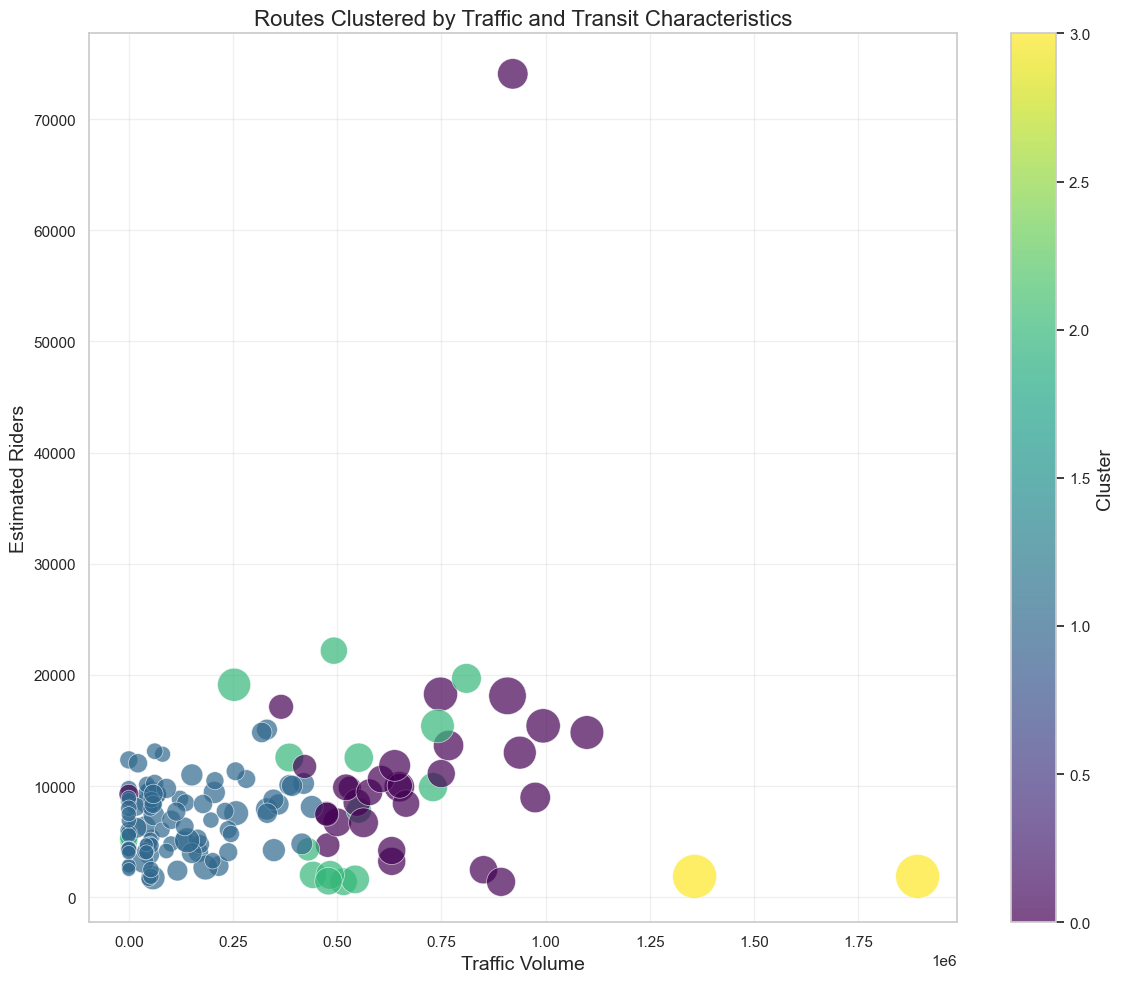

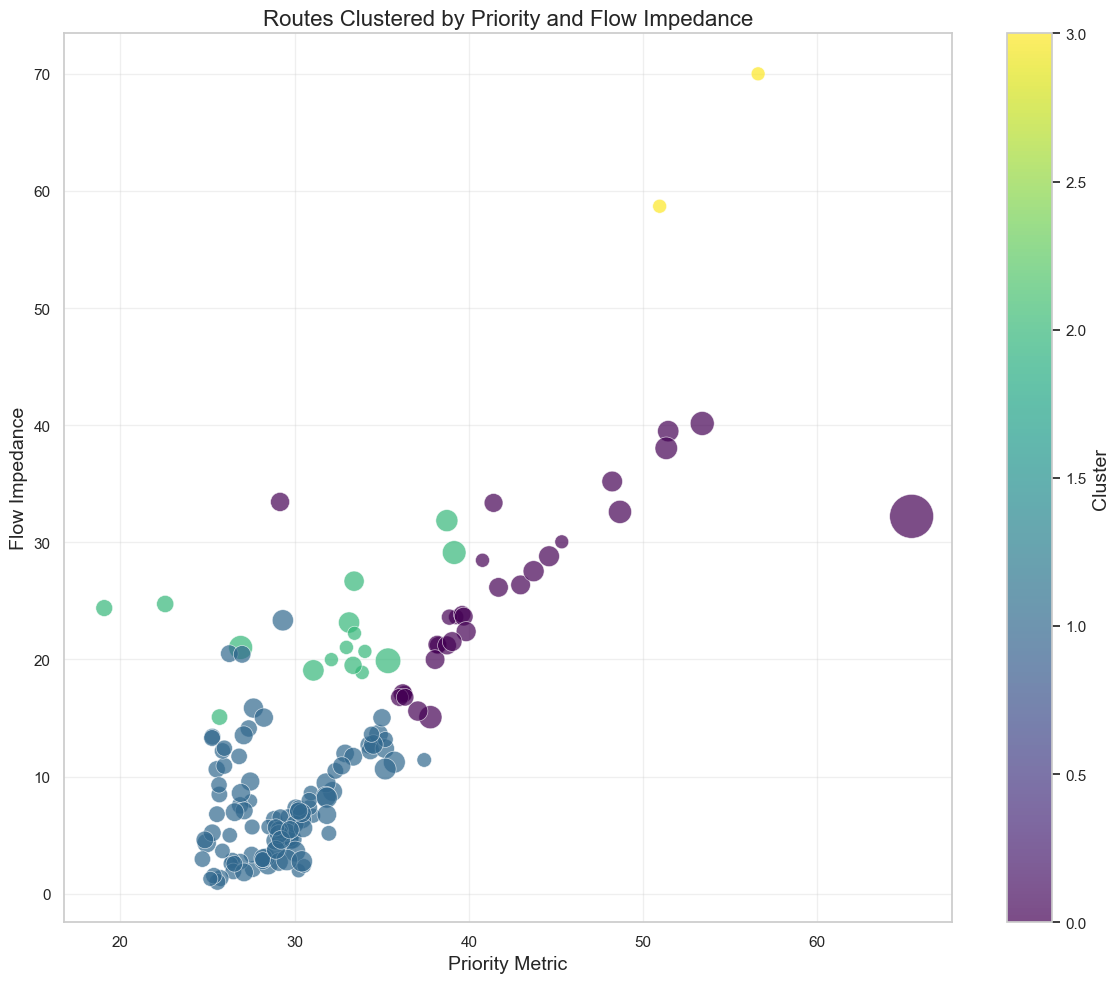

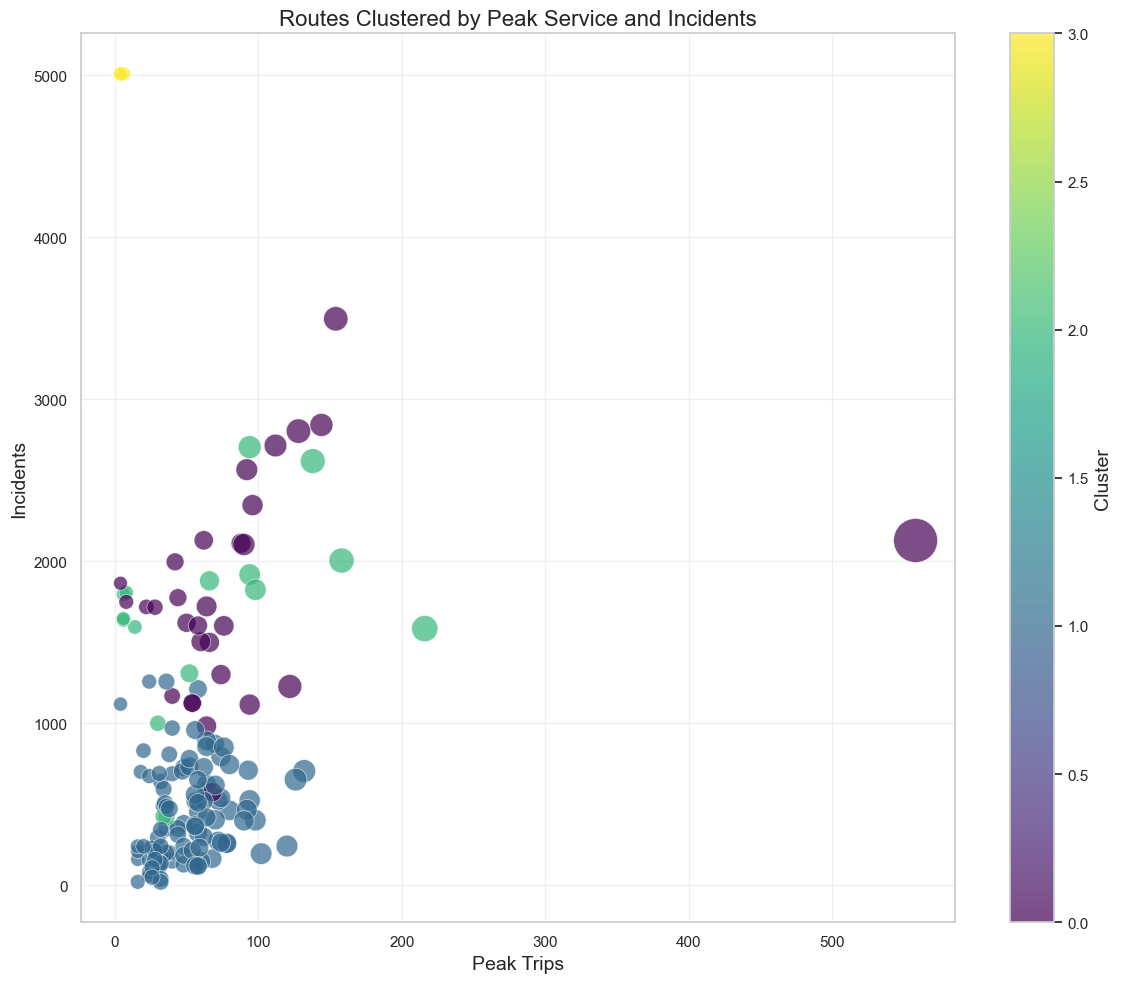

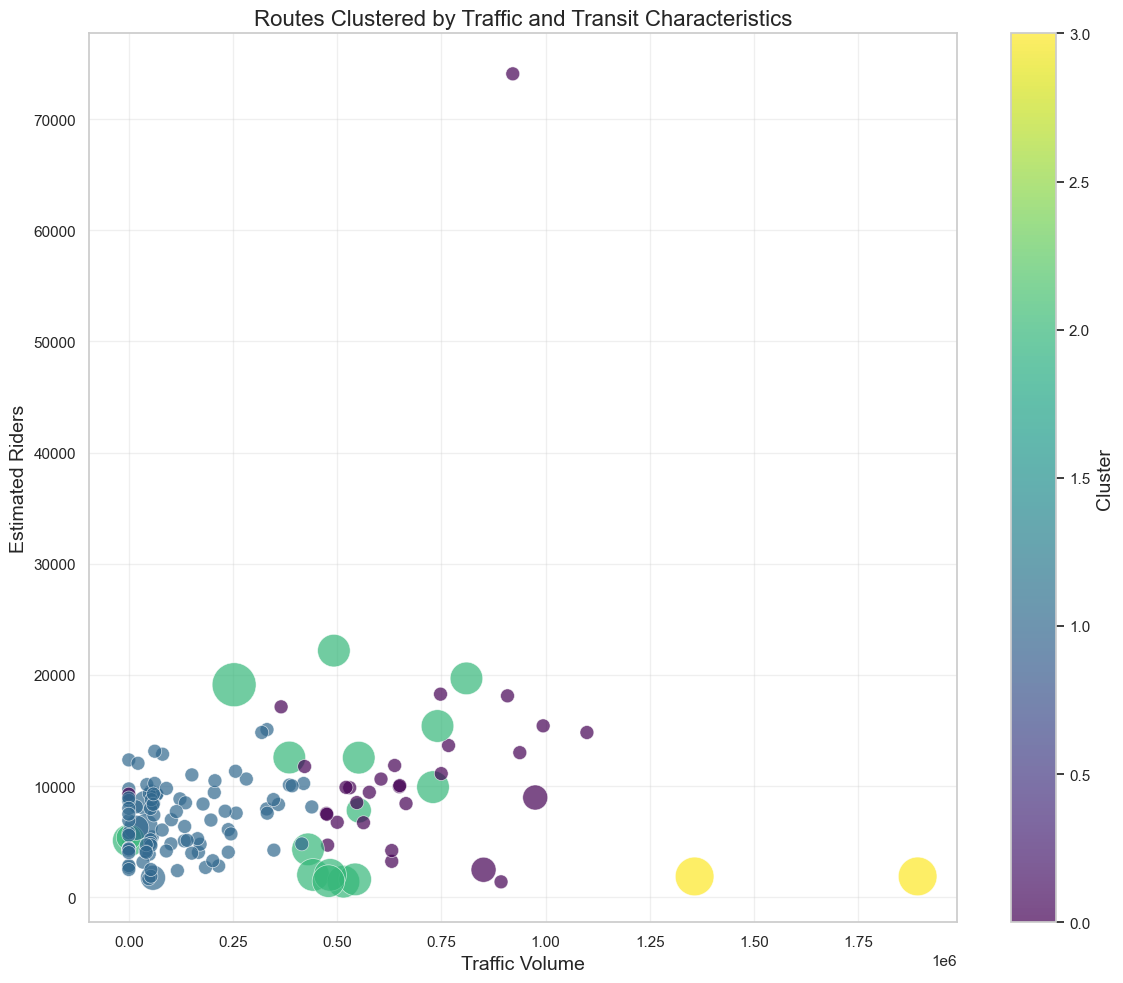

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# This assumes df already has your data and cluster assignments

# Create bubble chart visualization of clusters
def plot_bubble_chart_clusters(df, x_col, y_col, size_col, cluster_col='Cluster', 
                               title=None, alpha=0.7, figsize=(12, 10)):
    """
    Create a bubble chart visualization of clusters.
    
    Parameters:
    df (DataFrame): DataFrame with data
    x_col (str): Column name for x-axis
    y_col (str): Column name for y-axis
    size_col (str): Column name for bubble size
    cluster_col (str): Column name for cluster assignments
    title (str): Plot title
    alpha (float): Transparency of bubbles
    figsize (tuple): Figure size
    """
    # Get number of clusters
    n_clusters = df[cluster_col].nunique()
    
    # Create colormap
    cmap = plt.cm.viridis
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Normalize the size column for better visualization
    # Add small constant to avoid zero sizes
    size_values = df[size_col] + 1
    
    # Scale sizes between 100 and 1000 for visibility
    size_scaler = MinMaxScaler(feature_range=(100, 1000))
    sizes = size_scaler.fit_transform(size_values.values.reshape(-1, 1)).flatten()
    
    # Plot each cluster
    scatter = plt.scatter(
        df[x_col], 
        df[y_col],
        s=sizes,  # Use the scaled sizes
        c=df[cluster_col],  # Color by cluster
        cmap=cmap,
        alpha=alpha,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add labels for selected points (optional)
    # For readability, only label points above a certain size threshold
    # size_threshold = np.percentile(sizes, 75)  # Label top 25% by size
    # for i, row in df[sizes > size_threshold].iterrows():
    #     plt.annotate(
    #         str(int(row['Route_Short_Name'])),
    #         (row[x_col], row[y_col]),
    #         ha='center',
    #         va='center',
    #         fontsize=9,
    #         color='white',
    #         fontweight='bold'
    #     )
    
    # Set title and labels
    if title is None:
        title = f'Routes Clustered by {x_col} and {y_col}'
    plt.title(title, fontsize=16)
    plt.xlabel(x_col.replace('_', ' ').title(), fontsize=14)
    plt.ylabel(y_col.replace('_', ' ').title(), fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster', fontsize=14)
    
    # Add grid
    plt.grid(alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    return scatter

# Create different bubble chart visualizations to explore your data

# 1. Traffic Volume vs Estimated Riders (sized by Incidents)
plot_bubble_chart_clusters(
    df,
    x_col='Traffic_Volume',
    y_col='estimated_riders',
    size_col='Incidents',
    title='Routes Clustered by Traffic and Transit Characteristics'
)

# 2. Priority Metric vs Flow Impedance (sized by daily trips)
plot_bubble_chart_clusters(
    df,
    x_col='priority_metric',
    y_col='flow_impedance',
    size_col='daily_trips',
    title='Routes Clustered by Priority and Flow Impedance'
)

# 3. Peak Trips vs Incidents (sized by estimated riders)
plot_bubble_chart_clusters(
    df,
    x_col='peak_trips',
    y_col='Incidents',
    size_col='estimated_riders',
    title='Routes Clustered by Peak Service and Incidents'
)

# 4. Custom visualization showing key metrics for highlighting in report
# This will create a visualization similar to the one you showed
plot_bubble_chart_clusters(
    df,
    x_col='Traffic_Volume',
    y_col='estimated_riders',
    size_col='Number_of_Bus-Only-Lanes',  # Size by number of bus lanes
    title='Routes Clustered by Traffic and Transit Characteristics'
)

# You can create more visualizations with different combinations of variables
# Based on which aspects of the data you want to highlight